This is a Tensorflow implementation of the [Vesuvius Challenge: Ink Detection tutorial](https://www.kaggle.com/code/jpposma/vesuvius-challenge-ink-detection-tutorial). 

In [9]:
import gc
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import PIL.Image as Image

import tensorflow as tf

In [10]:
tf.random.set_seed(10)
np.random.seed(10)

path = './train/1'
depth = (27, 37)
radius = 30
rect = ((1100, 3500), 700, 950)
max_steps = 30_000
lr = 0.03
batch_size = 32

# Create dataset

In [11]:
def select_pixels(path: str, radius: int, rect: tuple = None, include: bool = False) -> (np.ndarray):
    """
    Select pixels.
    
    :param path: Location of the data.
    :param radius: Size of the area around the pixel.
    :param depth: Range of slices used.
    :param rect: Rectangular area defined by the tuple ((x0, y0), width, height). 
    :param include: Whether to return the pixels inside (True) or outside (False) the rectangular area.
    """
    
    mask = np.array(Image.open(os.path.join(path, 'mask.png')), dtype='int')
    height, width = mask.shape
    
    p = np.argwhere(mask == 1)
    p = p[(p[:, 0] > radius) & (p[:, 1] > radius) & (p[:, 0] + radius + 1 < height - radius) & (p[:, 1] + radius + 1 < width)]
    
    if rect is None:
        return p
    
    (xmin, ymin), width, height = rect
    xmax, ymax = (xmin + width), (ymin + height)
    
    if include:
        return p[(p[:, 1] > xmin) & (p[:, 1] < xmax) & (p[:, 0] > ymin) & (p[:, 0] < ymax)]
    
    return p[(p[:, 1] < xmin) | (p[:, 1] > xmax) | (p[:, 0] < ymin) | (p[:, 0] > ymax)]


def load_data(path: str, depth: tuple):
    """
    Load data from disc.
    
    :param path: Location of the data.
    :param depth: Range of slices used.
    """
    
    targets = np.array(Image.open(os.path.join(path, 'inklabels.png')), dtype='int')
    height, width = targets.shape
    
    images = []
    
    for d in range(*depth):
        image = np.array(Image.open(f'{path}/surface_volume/{d :02}.tif'), dtype='float32').reshape(height, width, 1)
        images.append(image / 65535.0)
        
    images = np.stack(images)
    
    return images, targets


class Dataset(tf.keras.utils.Sequence):
    
    def __init__(
        self, 
        images: np.ndarray, 
        targets: np.ndarray, 
        pixels: np.ndarray, 
        radius: int, 
        batch_size: int, 
        max_steps: int = None, 
        shuffle: bool = False
    ):
        """
        :param images: Array of images.
        :param targets: Array of targets.
        :param pixels: Array of pixels.
        :param radius: Size of the area around the pixel.
        :param batch_size: Batch size.
        :param max_steps: Total number of batches.
        :param shuffle: Wheter to shuffle the data.
        """
        
        self.images = images
        self.targets = targets
        self.pixels = pixels
        self.radius = radius
        self.batch_size = batch_size
        
        if shuffle:
            np.random.shuffle(self.pixels)
            
        if max_steps is not None:
            self.pixels = self.pixels[:self.batch_size * max_steps]
            
        
    def _shape(self):
        return (self.images.shape[0], int(self.radius * 2 + 1), int(self.radius * 2 + 1), 1)

        
    def __getitem__(self, index):
        
        radius = self.radius
        pixels = self.pixels[(index * self.batch_size):((index + 1) * self.batch_size)]
        
        images, targets = [], []
        
        for p in pixels:
            i, j = p[0], p[1]
            
            images.append(self.images[:, (i - radius):(i + radius + 1), (j - radius):(j + radius + 1), :])
            targets.append(self.targets[i, j])
        
        return np.array(images), np.array(targets)
    
    def __len__(self):
        return np.ceil(self.pixels.shape[0] / self.batch_size).astype('int')

/var/folders/cb/_zkpqrld6373byc18vv444vr0000gn/T/ipykernel_48017/4277091556.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


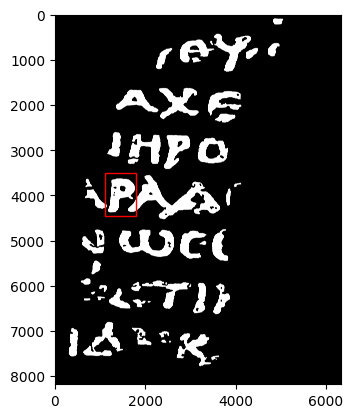

In [12]:
images, targets = load_data(path, depth)

train_pixels = select_pixels(path, radius, rect, include=False)
train = Dataset(images, targets, train_pixels, radius, batch_size=batch_size, shuffle=True, max_steps=max_steps)

valid_pixels = select_pixels(path, radius, rect, include=True)
valid = Dataset(images, targets, valid_pixels, radius, batch_size=batch_size, shuffle=False)


fig, ax = plt.subplots()
ax.imshow(targets, cmap='gray')
ax.add_patch(patches.Rectangle(*rect, edgecolor='r', facecolor='none'))
fig.show()

# Train model

In [14]:
class OneCycleScheduler(tf.keras.callbacks.Callback):
    """
    https://www.avanwyk.com/tensorflow-2-super-convergence-with-the-1cycle-policy/
    """
    
    def __init__(self, lr_max, steps, mom_min=0.85, mom_max=0.95, phase_1_pct=0.3, div_factor=25.):
        super(OneCycleScheduler, self).__init__()
        
        lr_min = lr_max / div_factor
        final_lr = lr_max / (div_factor * 1e4)
        phase_1_steps = steps * phase_1_pct
        phase_2_steps = steps - phase_1_steps
        
        self.phase_1_steps = phase_1_steps
        self.phase_2_steps = phase_2_steps
        self.phase = 0
        self.step = 0
        
        self.phases = [
            [CosineAnnealer(lr_min, lr_max, phase_1_steps), CosineAnnealer(mom_max, mom_min, phase_1_steps)], 
            [CosineAnnealer(lr_max, final_lr, phase_2_steps), CosineAnnealer(mom_min, mom_max, phase_2_steps)]
        ]
        
        self.lrs = []
        self.moms = []

    def on_train_begin(self, logs=None):
        self.phase = 0
        self.step = 0

        self.set_lr(self.lr_schedule().start)
        self.set_momentum(self.mom_schedule().start)
        
    def on_train_batch_begin(self, batch, logs=None):
        self.lrs.append(self.get_lr())
        self.moms.append(self.get_momentum())

    def on_train_batch_end(self, batch, logs=None):
        self.step += 1
        if self.step >= self.phase_1_steps:
            self.phase = 1
            
        self.set_lr(self.lr_schedule().step())
        self.set_momentum(self.mom_schedule().step())
        
    def get_lr(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.lr)
        except AttributeError:
            return None
        
    def get_momentum(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.momentum)
        except AttributeError:
            return None
        
    def set_lr(self, lr):
        try:
            tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        except AttributeError:
            pass # ignore
        
    def set_momentum(self, mom):
        try:
            tf.keras.backend.set_value(self.model.optimizer.momentum, mom)
        except AttributeError:
            pass # ignore

    def lr_schedule(self):
        return self.phases[self.phase][0]
    
    def mom_schedule(self):
        return self.phases[self.phase][1]
    
    
class CosineAnnealer:
    
    def __init__(self, start, end, steps):
        self.start = start
        self.end = end
        self.steps = steps
        self.n = 0
        
    def step(self):
        self.n += 1
        cos = np.cos(np.pi * (self.n / self.steps)) + 1
        return self.end + (self.start - self.end) / 2. * cos
    
    
class LogBatchMetricsCallback(tf.keras.callbacks.Callback):
    
    def __init__(self):
        super().__init__()
        self._metrics = {'loss': [], 'lr': []}
        
    
    def on_train_batch_end(self, batch, logs=None): 
        self._metrics['loss'].append(logs['loss'])
        self._metrics['lr'].append(logs['lr'])
        
        
class TrackLRCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, optimizer):
        super().__init__()
        self.optimizer = optimizer
    
    def on_batch_end(self, batch, logs):
        logs.update({'lr' : self.optimizer.lr.numpy()})
        
    def on_epoch_end(self, epoch, logs):
        logs.update({'lr' : self.optimizer.lr.numpy()})

In [16]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=train._shape()),
    tf.keras.layers.Conv3D(filters=16, kernel_size=3, activation=None, padding='same'),
    tf.keras.layers.MaxPool3D(),
    tf.keras.layers.Conv3D(filters=32, kernel_size=3, activation=None, padding='same'),
    tf.keras.layers.MaxPool3D(),
    tf.keras.layers.Conv3D(filters=64, kernel_size=3, activation=None, padding='same'),
    tf.keras.layers.MaxPool3D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, 'relu'),
    tf.keras.layers.Dense(1, 'sigmoid'),
])

model.summary()

loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.SGD(lr)

track_lr = TrackLRCallback(optimizer)
batch_metrics = LogBatchMetricsCallback()
lr_schedule = OneCycleScheduler(lr, max_steps)

model.compile(loss=loss, optimizer=optimizer)
_ = model.fit(train, callbacks=[track_lr, batch_metrics, lr_schedule])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 10, 61, 61, 16) │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 5, 30, 30, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 5, 30, 30, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 2, 15, 15, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 2, 15, 15, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 1, 7, 7, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 471,329 (1.80 MB)

 Trainable params: 471,329 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

AttributeError: 'SGD' object has no attribute 'lr'

In [ ]:
history = pd.DataFrame(batch_metrics._metrics)

fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
history.loss.plot(ax=ax[0]).set_title('loss')
history.lr.plot(ax=ax[1]).set_title('lr')
fig.tight_layout()
fig.show()


del train
_ = gc.collect()

# Predict

In [ ]:
y_pred = model.predict(valid)

del valid, model
_ = gc.collect()

In [ ]:
_, width, height = rect

fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(y_pred.reshape((height - 1), (width - 1)), cmap='gray')
fig.show()